<a href="https://colab.research.google.com/github/raghava0071/amadeus-flight-price-fluctuations/blob/main/Flight_Data_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install requests
import os, requests

In [2]:
# Set your credentials for THIS runtime only
os.environ["wbJCQz7UiGdboStDuGjL6HGVup0cwrd9"] = "wbJCQz7UiGdboStDuGjL6HGVup0cwrd9"       # a.k.a. Client ID
os.environ["CprY2OXmlW5V3AFH"] = "CprY2OXmlW5V3AFH"  # a.k.a. Client Secret


In [3]:
# 1) Get OAuth token (Client Credentials grant)
tok = requests.post(
  "https://test.api.amadeus.com/v1/security/oauth2/token",
  data={
    "grant_type": "client_credentials",
    "client_id": os.getenv("wbJCQz7UiGdboStDuGjL6HGVup0cwrd9"),
    "client_secret": os.getenv("CprY2OXmlW5V3AFH"),
  },
  timeout=60
)
print("Token status:", tok.status_code)
access_token = tok.json().get("access_token")


Token status: 200


In [4]:
# 2) Tiny test call (Flight Offers Search)
r = requests.get(
  "https://test.api.amadeus.com/v2/shopping/flight-offers",
  headers={"Authorization": f"Bearer {access_token}"},
  params={"originLocationCode":"MIA","destinationLocationCode":"BOM","departureDate":"2025-12-04","adults":1,"max":3},
  timeout=60
)
print("API status:", r.status_code)
print(r.text[:300])

API status: 200
{"meta":{"count":3,"links":{"self":"https://test.api.amadeus.com/v2/shopping/flight-offers?originLocationCode=MIA&destinationLocationCode=BOM&departureDate=2025-12-04&adults=1&max=3"}},"data":[{"type":"flight-offer","id":"1","source":"GDS","instantTicketingRequired":false,"nonHomogeneous":false,"one


In [6]:
# A1) Find cached dates/prices for a route (Test env)
AMAD_TEST_BASE = "https://test.api.amadeus.com"

def get_token(base=AMAD_TEST_BASE):
    import requests, os
    r = requests.post(
        f"{base}/v1/security/oauth2/token",
        data={
            "grant_type": "client_credentials",
            "client_id": os.getenv("wbJCQz7UiGdboStDuGjL6HGVup0cwrd9"),
            "client_secret": os.getenv("CprY2OXmlW5V3AFH"),
        },
        timeout=60
    )
    r.raise_for_status()
    return r.json()["access_token"]

def cheapest_dates(token, origin, dest, one_way=False, max_price=None, non_stop=None):
    import requests
    headers = {"Authorization": f"Bearer {token}"}
    params = {"origin": origin, "destination": dest}
    if one_way: params["oneWay"] = "true"
    if max_price: params["maxPrice"] = max_price
    if non_stop is not None: params["nonStop"] = str(non_stop).lower()
    r = requests.get(f"{AMAD_TEST_BASE}/v1/shopping/flight-dates", headers=headers, params=params, timeout=60)
    print("dates status:", r.status_code)
    return r.json()

token = get_token()
dates_payload = cheapest_dates(token, "MIA", "BOM")  # try your route first
len(dates_payload.get("data", [])), dates_payload.get("data", [])[:3]


dates status: 404


(0, [])

In [10]:
if not dates_payload.get("data"):
    dates_payload = cheapest_dates(token, "MAD", "BCN")


In [8]:
import requests, pandas as pd

def search_flights(token, origin, dest, depart, ret=None, adults=1, currency="USD", max_results=50, base=AMAD_TEST_BASE):
    headers = {"Authorization": f"Bearer {token}"}
    params = {
        "originLocationCode": origin,
        "destinationLocationCode": dest,
        "departureDate": depart,
        "adults": adults,
        "currencyCode": currency,
        "max": max_results,
    }
    if ret: params["returnDate"] = ret
    r = requests.get(f"{base}/v2/shopping/flight-offers", headers=headers, params=params, timeout=60)
    print("offers status:", r.status_code, depart, "→", ret)
    return r.json()

def parse_offers(payload):
    data = payload.get("data", [])
    dicts = payload.get("dictionaries", {})
    carriers = dicts.get("carriers", {})
    rows = []
    for item in data:
        price = float(item["price"]["grandTotal"]); currency = item["price"]["currency"]
        itin0 = item["itineraries"][0]; seg0 = itin0.get("segments", [])
        out_stops = max(0, len(seg0)-1)
        out_carriers = ",".join({carriers.get(s["carrierCode"], s["carrierCode"]) for s in seg0})
        out_depart = seg0[0]["departure"]["at"] if seg0 else None
        out_arrive = seg0[-1]["arrival"]["at"] if seg0 else None
        row = {"price": price, "currency": currency, "out_stops": out_stops,
               "out_carriers": out_carriers, "out_depart": out_depart, "out_arrive": out_arrive}
        if len(item["itineraries"]) > 1:
            seg1 = item["itineraries"][1].get("segments", [])
            row.update({
                "ret_stops": max(0, len(seg1)-1),
                "ret_depart": seg1[0]["departure"]["at"] if seg1 else None,
                "ret_arrive": seg1[-1]["arrival"]["at"] if seg1 else None
            })
        rows.append(row)
    return pd.DataFrame(rows).sort_values("price") if rows else pd.DataFrame()

# pick top 3 cheapest options from the date cache and fetch live offers for them
from datetime import datetime
date_rows = dates_payload.get("data", [])
date_rows = sorted(date_rows, key=lambda d: float(d["price"]["total"]))[:3] if date_rows else []
all_df = []
for d in date_rows:
    depart = d.get("departureDate")
    ret = d.get("returnDate")
    offers = search_flights(token, "MIA", "BOM", depart, ret, adults=1, currency="USD")
    all_df.append(parse_offers(offers))

df = pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()
print("Total offers:", len(df))
df.head(10)


offers status: 200 2025-10-04 → 2025-10-06
offers status: 200 2025-10-04 → 2025-10-07
offers status: 200 2025-10-04 → 2025-10-08
Total offers: 134


,price,currency,out_stops,out_carriers,out_depart,out_arrive,ret_stops,ret_depart,ret_arrive
0,934.97,USD,1,TURKISH AIRLINES,2025-10-04T22:15:00,2025-10-06T04:55:00,1,2025-10-06T06:55:00,2025-10-06T20:20:00
1,1519.17,USD,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,1,2025-10-06T04:20:00,2025-10-06T16:50:00
2,1519.17,USD,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,1,2025-10-06T04:10:00,2025-10-06T16:50:00
3,1521.77,USD,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,1,2025-10-06T04:20:00,2025-10-07T10:10:00
4,1521.77,USD,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,1,2025-10-06T04:10:00,2025-10-07T10:10:00
5,1594.17,USD,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T08:15:00,1,2025-10-06T22:25:00,2025-10-07T10:05:00
6,1594.17,USD,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T08:15:00,1,2025-10-06T19:30:00,2025-10-07T10:05:00
7,1594.17,USD,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T14:15:00,1,2025-10-06T22:25:00,2025-10-07T10:05:00
8,1594.17,USD,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T14:15:00,1,2025-10-06T19:30:00,2025-10-07T10:05:00
9,2232.17,USD,1,AIR FRANCE,2025-10-04T16:35:00,2025-10-05T23:20:00,2,2025-10-06T19:00:00,2025-10-07T14:15:00


**upgrade the parser to include durations (out + return) and a few helpful features**

In [11]:
# Helper: ISO8601 duration (e.g., "PT17H25M") -> minutes
def dur_to_min(s):
    if not isinstance(s, str):
        return None
    s = s.replace("PT","")
    hours = 0
    mins = 0
    if "H" in s:
        parts = s.split("H")
        hours = int(parts[0]) if parts[0].isdigit() else 0
        s = parts[1] if len(parts) > 1 else ""
    if "M" in s:
        mins = int(s.replace("M","")) if s.replace("M","").isdigit() else 0
    return hours*60 + mins

# New parser that keeps durations and route/date context
def parse_offers_v2(payload, origin, dest, depart, ret):
    data = payload.get("data", [])
    dicts = payload.get("dictionaries", {})
    carriers = dicts.get("carriers", {})
    rows = []
    for item in data:
        price = float(item["price"]["grandTotal"])
        currency = item["price"]["currency"]

        # Outbound
        itin0 = item["itineraries"][0]
        out_dur = itin0.get("duration")                 # e.g., "PT17H25M"
        out_dur_min = dur_to_min(out_dur)
        seg0 = itin0.get("segments", [])
        out_stops = max(0, len(seg0) - 1)
        out_carriers = ",".join({carriers.get(s["carrierCode"], s["carrierCode"]) for s in seg0})
        out_depart = seg0[0]["departure"]["at"] if seg0 else None
        out_arrive = seg0[-1]["arrival"]["at"] if seg0 else None

        # Return (optional)
        ret_dur, ret_dur_min, ret_stops, ret_carriers, ret_depart, ret_arrive = None, None, None, None, None, None
        if len(item["itineraries"]) > 1:
            itin1 = item["itineraries"][1]
            ret_dur = itin1.get("duration")
            ret_dur_min = dur_to_min(ret_dur)
            seg1 = itin1.get("segments", [])
            ret_stops = max(0, len(seg1) - 1)
            ret_carriers = ",".join({carriers.get(s["carrierCode"], s["carrierCode"]) for s in seg1})
            ret_depart = seg1[0]["departure"]["at"] if seg1 else None
            ret_arrive = seg1[-1]["arrival"]["at"] if seg1 else None

        rows.append({
            "route": f"{origin}-{dest}",
            "depart_date": depart,
            "return_date": ret,
            "price": price,
            "currency": currency,

            "out_duration": out_dur,
            "out_duration_min": out_dur_min,
            "out_stops": out_stops,
            "out_carriers": out_carriers,
            "out_depart": out_depart,
            "out_arrive": out_arrive,

            "ret_duration": ret_dur,
            "ret_duration_min": ret_dur_min,
            "ret_stops": ret_stops,
            "ret_carriers": ret_carriers,
            "ret_depart": ret_depart,
            "ret_arrive": ret_arrive
        })
    import pandas as pd
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["price","out_duration_min"], ascending=[True, True]).reset_index(drop=True)
        # helpful helper columns
        df["carrier_main"] = df["out_carriers"].fillna("").str.split(",").str[0]
        df["total_duration_min"] = df[["out_duration_min","ret_duration_min"]].sum(axis=1, min_count=1)
        df["price_per_hour"] = df["price"] / (df["total_duration_min"]/60.0)
    return df


**rebuild your DataFrame for the 3 date pairs you tested**

In [12]:
# Re-run the three date pairs you tested (adjust as needed)
date_pairs = [
    ("2025-10-04", "2025-10-06"),
    ("2025-10-04", "2025-10-07"),
    ("2025-10-04", "2025-10-08"),
]

all_df = []
for depart, ret in date_pairs:
    payload = search_flights(token, "MIA", "BOM", depart, ret, adults=1, currency="USD")
    df_part = parse_offers_v2(payload, "MIA", "BOM", depart, ret)
    all_df.append(df_part)

df = pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()
print(df.shape)
df.head(10)


offers status: 200 2025-10-04 → 2025-10-06
offers status: 200 2025-10-04 → 2025-10-07
offers status: 200 2025-10-04 → 2025-10-08
(134, 20)


,route,depart_date,return_date,price,currency,out_duration,out_duration_min,out_stops,out_carriers,out_depart,out_arrive,ret_duration,ret_duration_min,ret_stops,ret_carriers,ret_depart,ret_arrive,carrier_main,total_duration_min,price_per_hour
0,MIA-BOM,2025-10-04,2025-10-06,934.97,USD,PT21H10M,1270,1,TURKISH AIRLINES,2025-10-04T22:15:00,2025-10-06T04:55:00,PT22H55M,1375,1,TURKISH AIRLINES,2025-10-06T06:55:00,2025-10-06T20:20:00,TURKISH AIRLINES,2645,21.209149
1,MIA-BOM,2025-10-04,2025-10-06,1519.17,USD,PT21H,1260,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,PT22H,1320,1,QATAR AIRWAYS,2025-10-06T04:20:00,2025-10-06T16:50:00,QATAR AIRWAYS,2580,35.329535
2,MIA-BOM,2025-10-04,2025-10-06,1519.17,USD,PT21H,1260,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,PT22H10M,1330,1,QATAR AIRWAYS,2025-10-06T04:10:00,2025-10-06T16:50:00,QATAR AIRWAYS,2590,35.193127
3,MIA-BOM,2025-10-04,2025-10-06,1521.77,USD,PT21H,1260,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,PT39H20M,2360,1,QATAR AIRWAYS,2025-10-06T04:20:00,2025-10-07T10:10:00,QATAR AIRWAYS,3620,25.222707
4,MIA-BOM,2025-10-04,2025-10-06,1521.77,USD,PT21H,1260,1,QATAR AIRWAYS,2025-10-04T19:40:00,2025-10-06T02:10:00,PT39H30M,2370,1,QATAR AIRWAYS,2025-10-06T04:10:00,2025-10-07T10:10:00,QATAR AIRWAYS,3630,25.153223
5,MIA-BOM,2025-10-04,2025-10-06,1594.17,USD,PT22H50M,1370,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T08:15:00,PT21H10M,1270,1,EMIRATES,2025-10-06T22:25:00,2025-10-07T10:05:00,EMIRATES,2640,36.231136
6,MIA-BOM,2025-10-04,2025-10-06,1594.17,USD,PT22H50M,1370,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T08:15:00,PT24H5M,1445,1,EMIRATES,2025-10-06T19:30:00,2025-10-07T10:05:00,EMIRATES,2815,33.978757
7,MIA-BOM,2025-10-04,2025-10-06,1594.17,USD,PT28H50M,1730,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T14:15:00,PT21H10M,1270,1,EMIRATES,2025-10-06T22:25:00,2025-10-07T10:05:00,EMIRATES,3000,31.883400
8,MIA-BOM,2025-10-04,2025-10-06,1594.17,USD,PT28H50M,1730,1,EMIRATES,2025-10-04T23:55:00,2025-10-06T14:15:00,PT24H5M,1445,1,EMIRATES,2025-10-06T19:30:00,2025-10-07T10:05:00,EMIRATES,3175,30.126047
9,MIA-BOM,2025-10-04,2025-10-06,2232.17,USD,PT21H15M,1275,1,AIR FRANCE,2025-10-04T16:35:00,2025-10-05T23:20:00,PT28H45M,1725,2,AIR FRANCE,2025-10-06T19:00:00,2025-10-07T14:15:00,AIR FRANCE,3000,44.643400


**de-duplicate near-identical options**

In [13]:
if not df.empty:
    keep_cols = ["route","depart_date","return_date","carrier_main","out_stops","ret_stops"]
    df_dedup = df.sort_values(["price","total_duration_min"]).drop_duplicates(keep_cols, keep="first")
    print("Before:", len(df), "After de-dup:", len(df_dedup))
    df_dedup.head(10)
else:
    print("df is empty")


Before: 134 After de-dup: 32


find the “Pareto frontier” (cheapest vs fastest)

A flight is Pareto-optimal if no other option is both cheaper and faster. **bold text**

In [14]:
def pareto_frontier(pdf, price_col="price", dur_col="total_duration_min"):
    pdf = pdf.dropna(subset=[price_col, dur_col]).sort_values([price_col, dur_col]).reset_index(drop=True)
    frontier_idx = []
    best_dur = float("inf")
    for i, row in pdf.iterrows():
        if row[dur_col] < best_dur:
            frontier_idx.append(i)
            best_dur = row[dur_col]
    return pdf.loc[frontier_idx]

front = pareto_frontier(df_dedup)
print("Pareto flights:", len(front))
front[["route","depart_date","return_date","price","currency","total_duration_min","out_stops","carrier_main"]].head(15)


Pareto flights: 4


,route,depart_date,return_date,price,currency,total_duration_min,out_stops,carrier_main
0,MIA-BOM,2025-10-04,2025-10-07,774.97,USD,3315,1,TURKISH AIRLINES
1,MIA-BOM,2025-10-04,2025-10-08,784.97,USD,2665,1,TURKISH AIRLINES
2,MIA-BOM,2025-10-04,2025-10-08,903.37,USD,2620,1,AIR FRANCE
5,MIA-BOM,2025-10-04,2025-10-08,1122.17,USD,2580,1,QATAR AIRWAYS


**quick summaries you can talk about**

In [15]:
# Cheapest by return date
cheapest_by_return = (df_dedup
                      .groupby("return_date", as_index=False)
                      .agg(min_price=("price","min"))
                      .sort_values("min_price"))
cheapest_by_return

# Carrier comparison (avg price & count)
carrier_stats = (df_dedup
                 .groupby("carrier_main", as_index=False)
                 .agg(avg_price=("price","mean"), offers=("price","count")))
carrier_stats.sort_values("avg_price").head(10)

# Stops impact (avg price by stops)
stops_stats = (df_dedup
               .groupby("out_stops", as_index=False)
               .agg(avg_price=("price","mean"), offers=("price","count")))
stops_stats.sort_values("avg_price")


,out_stops,avg_price,offers
0,1,1582.290,20
1,2,2906.245,12


In [18]:
import sys

try:
    import matplotlib.pyplot as plt
except Exception:
    !pip -q install matplotlib
    import matplotlib.pyplot as plt


**charts (one plot per figure; all matplotlib)**

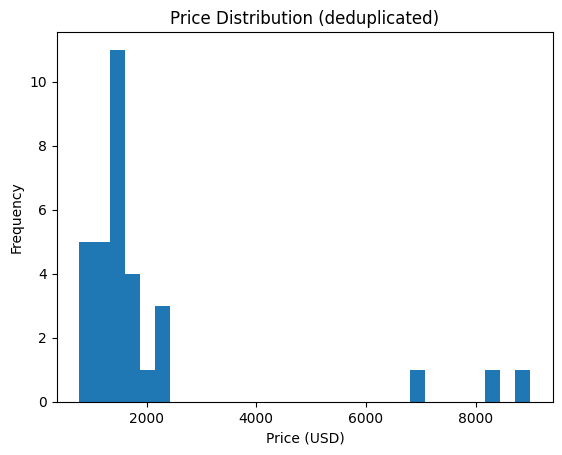

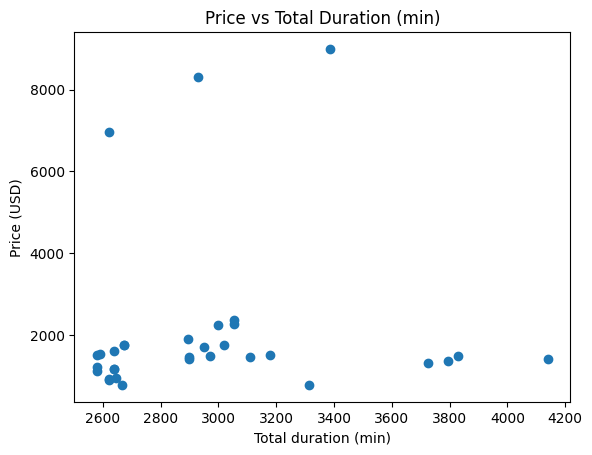

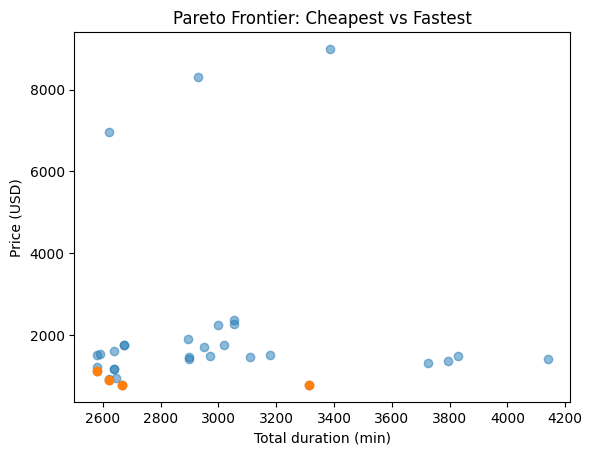

In [22]:
# Make sure df_dedup exists and has data
if "df_dedup" not in globals() or df_dedup is None or df_dedup.empty:
    raise ValueError("df_dedup is empty or undefined. Run the parsing/dedup cells first.")

# 1) Price distribution
plt.figure()
df_dedup["price"].dropna().plot(kind="hist", bins=30, title="Price Distribution (deduplicated)")
plt.xlabel("Price (USD)")
plt.show()

# 2) Price vs total duration
plt.figure()
tmp = df_dedup.dropna(subset=["total_duration_min"])
plt.scatter(tmp["total_duration_min"], tmp["price"])
plt.title("Price vs Total Duration (min)")
plt.xlabel("Total duration (min)")
plt.ylabel("Price (USD)")
plt.show()

# 3) Pareto frontier overlay (optional)
if "front" in globals() and front is not None and not front.empty:
    plt.figure()
    plt.scatter(tmp["total_duration_min"], tmp["price"], alpha=0.5)
    plt.scatter(front["total_duration_min"], front["price"])
    plt.title("Pareto Frontier: Cheapest vs Fastest")
    plt.xlabel("Total duration (min)")
    plt.ylabel("Price (USD)")
    plt.show()
else:
    print("Pareto set not available. Run: front = pareto_frontier(df_dedup)")


In [20]:
out_csv = "/content/miabom_offers_2025-10-04_variants.csv"
df_dedup.to_csv(out_csv, index=False)
out_csv


'/content/miabom_offers_2025-10-04_variants.csv'

In [25]:
git add .
git commit -m "feat: initial release (notebook + src + CI)"
git branch -M main
git remote add origin https://github.com/raghava0071/amadeus-flight-price-fluctuations.git
git push -u origin main


SyntaxError: invalid syntax (ipython-input-853834061.py, line 1)